<a href="https://colab.research.google.com/github/Utkarsh038/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/main/Oill_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Mounting  Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:


TRAIN_IMG_DIR = 'drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/'
TRAIN_MASK_DIR = 'drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/'

print(f"Path to training images: {TRAIN_IMG_DIR}")
print(f"Path to training masks: {TRAIN_MASK_DIR}")

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16


Path to training images: drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/
Path to training masks: drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/


Displaying sample images and their corresponding masks...


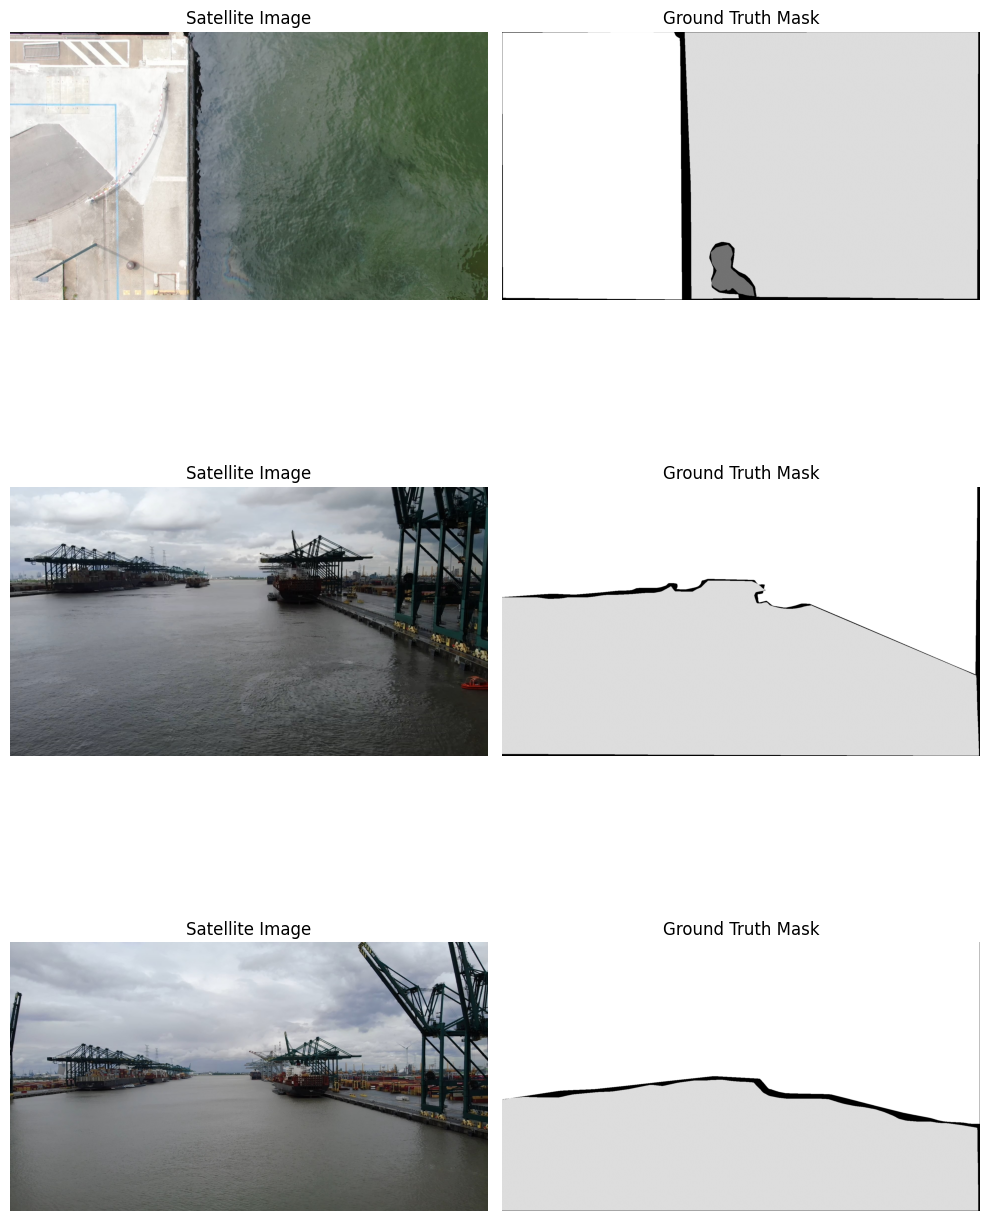

In [15]:
# ==============================================================================
# Step 3: Data Exploration - Visualize Sample Images and Masks
# ==============================================================================

# Get a list of all image and mask files
# Update paths to reflect the cloned repository location
TRAIN_IMG_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/'
TRAIN_MASK_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/'

train_image_files = sorted([os.path.join(TRAIN_IMG_DIR, f) for f in os.listdir(TRAIN_IMG_DIR)])
train_mask_files = sorted([os.path.join(TRAIN_MASK_DIR, f) for f in os.listdir(TRAIN_MASK_DIR)])

# Function to display images and masks
def display_samples(images, masks, count=3):
    plt.figure(figsize=(10, 5 * count))
    for i in range(count):
        # Load original image
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for plotting

        # Load mask image
        mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)

        plt.subplot(count, 2, 2 * i + 1)
        plt.title("Satellite Image")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(count, 2, 2 * i + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 3 samples
print("Displaying sample images and their corresponding masks...")
display_samples(train_image_files, train_mask_files, count=3)


Displaying a sample after preprocessing (resizing, noise reduction, and normalization)...


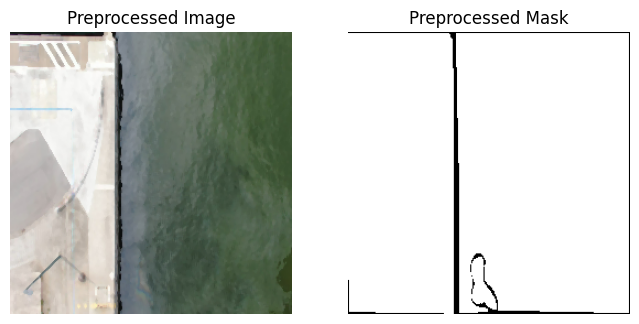

In [16]:
# ==============================================================================
# Data Preprocessing
# ==============================================================================

def preprocess_image(image_path, mask_path):


    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

#    For speckle Noise reduction
    def apply_median_filter(image_tensor):
        image_np = image_tensor.numpy().astype(np.uint8)

        filtered_image = cv2.medianBlur(image_np, 3)
        return filtered_image.astype(np.float32)

    img = tf.py_function(func=apply_median_filter, inp=[img], Tout=tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])

    # Normalize the image pixel values to be between 0 and 1
    img = img / 255.0

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest') # Use 'nearest' for masks
    # Normalize mask to be binary (0 or 1)
    mask = tf.cast(mask > 0, dtype=tf.float32)

    return img, mask


dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))


processed_dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)


print("\nDisplaying a sample after preprocessing (resizing, noise reduction, and normalization)...")
for img, mask in processed_dataset.take(1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Preprocessed Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Mask")
    plt.imshow(tf.squeeze(mask), cmap='gray')
    plt.axis('off')
    plt.show()


Displaying a sample after augmentation...


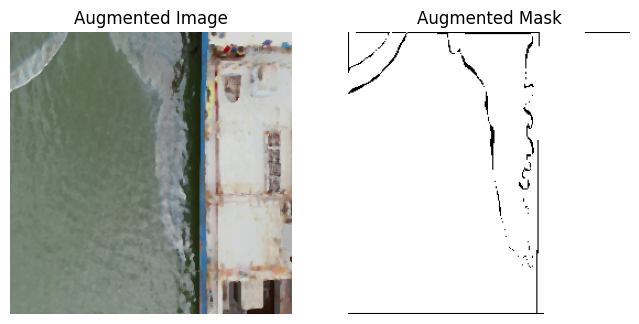


 (Data Exploration, Preprocessing, and Augmentation) is complete.


In [17]:
# ==============================================================================
# Data Augmentation
# ==============================================================================

def augment_data(image, mask):


    combined = tf.concat([image, mask], axis=-1)

    # Random horizontal flip
    combined = tf.image.random_flip_left_right(combined)

    # Random vertical flip
    combined = tf.image.random_flip_up_down(combined)

    # Separate the image and mask again
    image = combined[:, :, :3]
    mask = combined[:, :, 3:]

    # Brightness and contrast adjustments are applied only to the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 1.0) # Ensure values remain in [0, 1]

    return image, mask


train_dataset = (
    processed_dataset
    .cache()  # Cache data for performance
    .shuffle(buffer_size=1000)
    .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualize an augmented sample
print("\nDisplaying a sample after augmentation...")
for img, mask in train_dataset.take(1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Augmented Image")
    plt.imshow(img[0]) # Display the first image in the batch
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Augmented Mask")
    plt.imshow(tf.squeeze(mask[0]), cmap='gray') # Display the first mask in the batch
    plt.axis('off')
    plt.show()

print("\n (Data Exploration, Preprocessing, and Augmentation) is complete.")


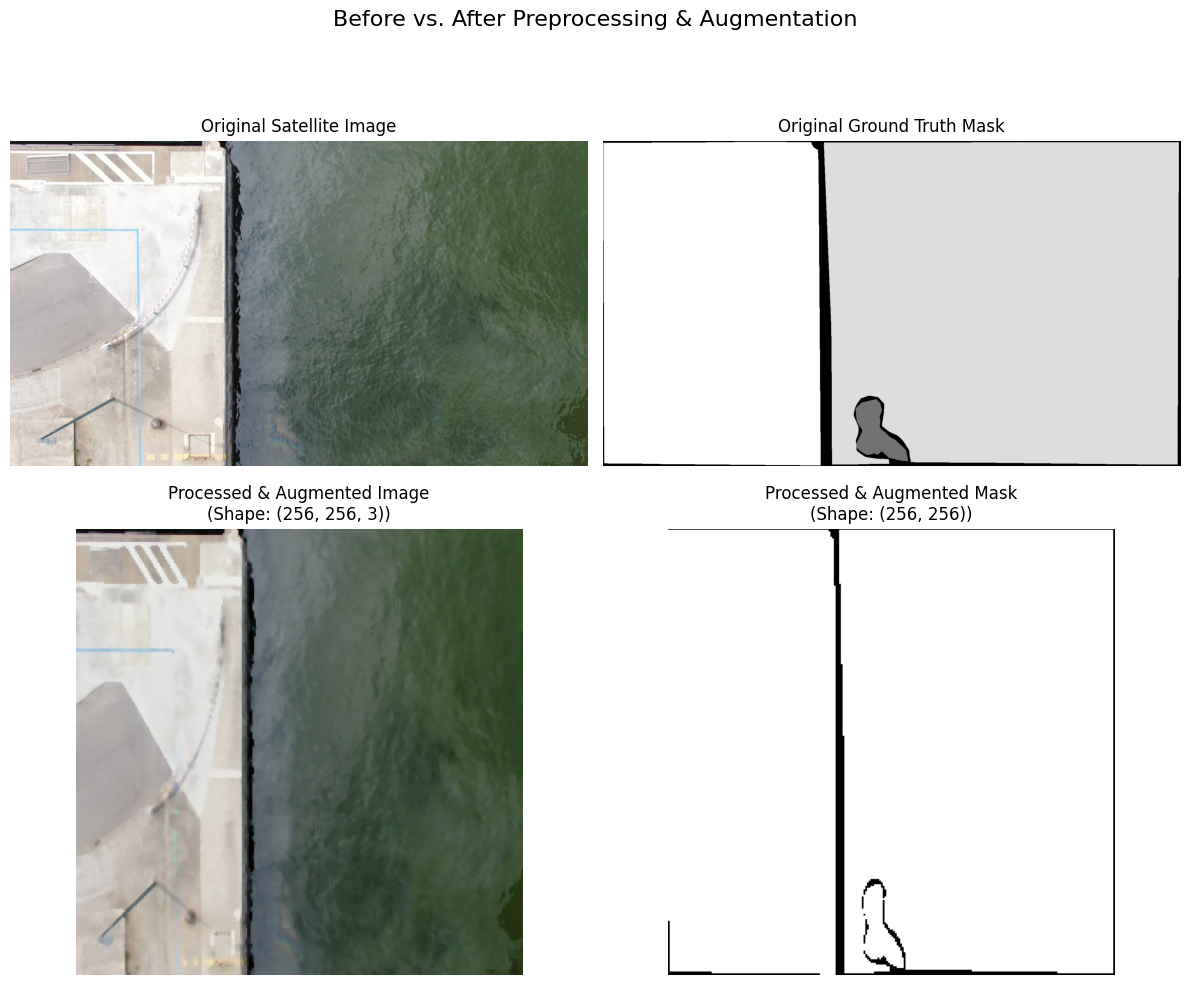

In [18]:
# ==============================================================================
#  Combined Before vs. After Visualization
# ==============================================================================


sample_image_path = train_image_files[0]
sample_mask_path = train_mask_files[0]


original_img = cv2.imread(sample_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)


processed_img, processed_mask = preprocess_image(sample_image_path, sample_mask_path)

augmented_img, augmented_mask = augment_data(processed_img, processed_mask)


plt.figure(figsize=(12, 10))
plt.suptitle("Before vs. After Preprocessing & Augmentation", fontsize=16)

# Top-left: Original Image
plt.subplot(2, 2, 1)
plt.title("Original Satellite Image")
plt.imshow(original_img)
plt.axis('off')

# Top-right: Original Mask
plt.subplot(2, 2, 2)
plt.title("Original Ground Truth Mask")
plt.imshow(original_mask, cmap='gray')
plt.axis('off')

# Bottom-left: Processed & Augmented Image
plt.subplot(2, 2, 3)
plt.title(f"Processed & Augmented Image\n(Shape: {augmented_img.shape})")
plt.imshow(augmented_img)
plt.axis('off')

# Bottom-right: Processed & Augmented Mask
plt.subplot(2, 2, 4)
plt.title(f"Processed & Augmented Mask\n(Shape: {tf.squeeze(augmented_mask).shape})")
plt.imshow(tf.squeeze(augmented_mask), cmap='gray') # Use tf.squeeze to remove the last dimension for plotting
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()